# Turbine type and position optimization with type specific boundary constraints

In this example, a layout optimization with different turbine types is performed with a random search solver. In addition, the boundaries of the problem are specific for the different types of wind turbines present.

**Install TOPFARM if needed**

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

Loading Python dependencies.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString

Loading PyWake dependencies.

In [3]:
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.power_ct_functions import CubePowerSimpleCt
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.utils.gradients import autograd
from py_wake import BastankhahGaussian

Loading TOPFARM dependencies.

In [4]:
import topfarm
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import TurbineTypePlotComponent
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver
from topfarm.drivers.random_search_driver import randomize_turbine_type, RandomizeTurbineTypeAndPosition
from topfarm.constraint_components.boundary import InclusionZone, ExclusionZone

Now we create our two types of wind turbines, specifying key parameters such as diameter, hub height and the CT curve.

In [5]:
# wind turbine types 
names=['tb1', 'tb2']
wts = WindTurbines(names=names,
                   diameters=[80, 120],
                   hub_heights=[70, 110],
                   powerCtFunctions=[CubePowerSimpleCt(ws_cutin=3, ws_cutout=25, ws_rated=12,
                                         power_rated=2000, power_unit='kW',
                                         ct=8 / 9, additional_models=[]),
                                     CubePowerSimpleCt(ws_cutin=3, ws_cutout=25, ws_rated=12,
                                         power_rated=3000, power_unit='kW',
                                         ct=8 / 9, additional_models=[])])

In [6]:
# wind farm model
wfm = BastankhahGaussian(Hornsrev1Site(), wts)

/home/ernie/code/TopFarm2/.pixi/envs/default/lib/python3.11/site-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


We include some boundaries in our domain that will be dependent on the type of wind turbine. There are four areas added individually: the main wind farm boundaries, added as a square of 3x3 km; a river that crosses the domain vertically; a road that crosses the domain horizontally; and a big building located in the left upper corner. 

The wind farm domain square is an inclusion zone, where the wind turbines are allowed to be placed, whereas the building, river and road are exclusion zones, where the wind turbines cannot be placed.

In [7]:
# geometries for boundary constraints 
default_ref = 100 # reference to buffer polygons

# wind farm main boundaries
x1 = [0, 3000, 3000, 0]
y1 = [0, 0, 3000, 3000]
b1 = np.transpose((x1, y1))
ie1 = 1
d1 = None
t1 = 'polygon'

# Buildings
x2 = [600, 1400, 1400, 600]
y2 = [1700, 1700, 2500, 2500]
b2 = np.transpose((x2, y2))
ie2 = 0
d2 = {'type': 'H',
      'multiplier': 4,
      'ref': 360}
t2 = 'polygon'
p2 = Polygon(b2)

# River
x3 = np.linspace(520, 2420, 16)
y3 = [   0,  133,  266,  400,  500,  600,  700,  733, 866, 1300, 1633,
       2100, 2400, 2533, 2700, 3000]
b3 = np.transpose((x3, y3))
ie3 = 0
d3 = {'type': 'D',
      'multiplier': 3,
      'ref': None}
t3 = 'line'
p3 = Polygon(LineString(b3).buffer(default_ref, join_style=2).exterior)

# Roads
x4 = np.linspace(0, 3000, 16)
y4 = [1095, 1038, 1110, 1006, 1028,  992,  977, 1052, 1076, 1064, 1073,
       1027,  964,  981, 1015, 1058]
b4 = np.transpose((x4, y4))
ie4 = 0
d4 = {'type': 'H',
      'multiplier': 3,
      'ref': None}
t4 = 'line'
p4 = Polygon(LineString(b4).buffer(default_ref, join_style=2).exterior)

We also set up the number of wind turbines as well as their initial positions. The turbine types are created randomly and the turbine coordinates in x and y are limited.

In [14]:
# Instantiate wind turbines

n_wt = 16 # desired number of turbines 

x_min, x_max = 0, 3000 # limits for x
y_min, y_max = 0, 3000 # limits for y

np.random.seed(42)
def initial_positions():
    wt_x, wt_y = np.random.uniform(x_min, x_max, n_wt), np.random.uniform(y_min, y_max, n_wt)
    wt_x = wt_x.flatten()
    wt_y = wt_y.flatten()
    return wt_x, wt_y

wt_x, wt_y = initial_positions()

# instantiate types 
types = np.random.choice(2, n_wt)

Then we group all geometries in a boundary component.

In [15]:
# group all geometries in a boundary component 
zones = [InclusionZone(b1),
         ExclusionZone(b2, dist2wt=lambda H: 4 * H - 360),
         ExclusionZone(b3, geometry_type='line', dist2wt=lambda D: 3 * D),
         ExclusionZone(b4, geometry_type='line', dist2wt=lambda D, H: max(D * 2, H * 3))
        ]

xybound = XYBoundaryConstraint(zones, boundary_type='turbine_specific', turbines=wts)

The objective function and its gradients is set up in addition to the `CostModelComponent`.

In [16]:
# AEP function and gradients (with autograd)
def aep_func(x, y, type, **kwargs):
    simres = wfm(x, y, type=type, **kwargs)
    return simres.aep(normalize_probabilities=True).values.sum()

def daep_func(x, y, type, **kwargs):
    grad = wfm.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'])(x, y)
    return grad

# AEP cost component
aep_comp = CostModelComponent(input_keys=[('x', wt_x), ('y', wt_y), ('type', types)],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              cost_gradient_function=daep_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('AEP', 0)],
                              output_unit='GWh')

Lastly, the `TopFarmProblem` is set up where both the layout and the turbine types are optimized simultaneously.

In [17]:
problem = TopFarmProblem(design_vars={'type': (np.zeros(n_wt), 0, int(len(names)-1)),
                                      'x': wt_x,
                                      'y': wt_y
                                      },
                          cost_comp=aep_comp,
                          constraints=[xybound, SpacingConstraint(240)],
                          driver=EasyRandomSearchDriver(RandomizeTurbineTypeAndPosition(max_step=1000), max_iter=100),
                          plot_comp=TurbineTypePlotComponent(names),
                          expected_cost=1e-2,
                         reports=False
                          )

100%|██████████| 4/4 [00:00<00:00, 1238.63it/s]

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


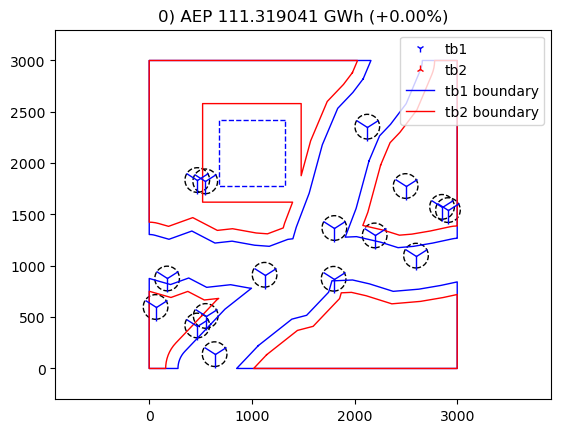

In [12]:
cost, state, recorder = problem.optimize()

We can print the final results for the turbine types and positions. It can be seen that the optimal turbine type is mostly turbine 2, which has a larger diameter than turbine 1. The optimizer chooses a bigger turbine to obtain a higher AEP while keeping the turbines within their respective boundaries.

In [13]:
state

{'type': array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]),
 'x': array([2745.64272794, 3000.        , 1118.1588701 ,  545.57092669,
        2821.41527158,  285.02689209,   72.15076084, 1844.20649685,
        2811.32567818, 3000.        , 2548.2021349 , 2463.01799821,
        2184.66520587, 2495.16690493, 3000.        , 1771.35619188]),
 'y': array([1483.69088609, 1416.41251156, 2843.00265332, 1474.38159436,
        2344.19439801,  449.84609788, 2862.49825861,    0.        ,
        1842.79324928,    0.        ,  589.48421389, 1949.90035583,
        1642.88551686, 1581.6654322 , 2989.20716355, 2800.0927231 ])}